In [255]:
import pandas as pd
import numpy as np

In [256]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [257]:
events_data = pd.read_csv('event_data_train.csv')
submissions_data = pd.read_csv('submissions_data_train.csv')

In [258]:
now = events_data.timestamp.max()
now

1526772811

In [259]:
events_data['date'] = pd.to_datetime(events_data.timestamp, unit='s')
events_data['day'] = events_data.date.dt.date
submissions_data['date'] = pd.to_datetime(submissions_data.timestamp, unit='s')
submissions_data['day'] = submissions_data.date.dt.date

In [260]:
events_data.head()

,step_id,timestamp,action,user_id,date,day
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15


In [261]:
submissions_data.head()

,step_id,timestamp,submission_status,user_id,date,day
0,31971,1434349275,correct,15853,2015-06-15 06:21:15,2015-06-15
1,31972,1434348300,correct,15853,2015-06-15 06:05:00,2015-06-15
2,31972,1478852149,wrong,15853,2016-11-11 08:15:49,2016-11-11
3,31972,1478852164,correct,15853,2016-11-11 08:16:04,2016-11-11
4,31976,1434348123,wrong,15853,2015-06-15 06:02:03,2015-06-15


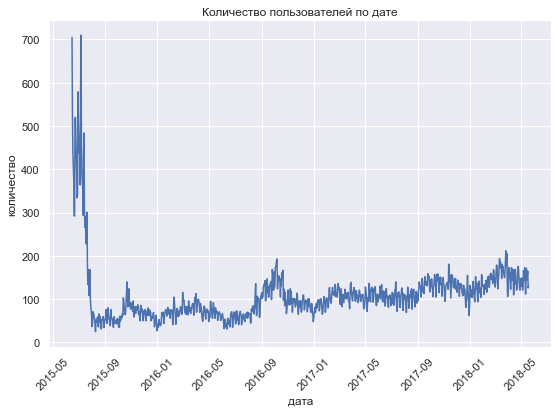

In [262]:
sns.set(rc={'figure.figsize': (9, 6)})
events_data.groupby('day').user_id.nunique().plot(title='Количество пользователей по дате', xlabel='дата', ylabel='количество').tick_params(axis='x', rotation=45)

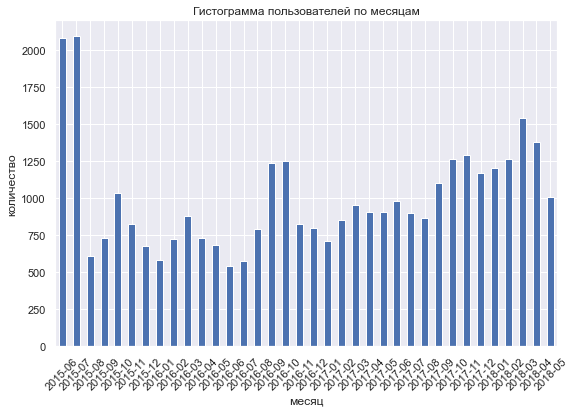

In [263]:
events_data['month'] = pd.to_datetime(events_data['timestamp'], unit='s').dt.to_period('M')
events_data.groupby('month').user_id.nunique().plot(kind='bar', title='Гистограмма пользователей по месяцам', xlabel='месяц', ylabel='количество').tick_params(axis='x', rotation=45)

In [264]:
user_events = events_data.pivot_table(
    index='user_id', columns='action', values='step_id', aggfunc='count', fill_value=0
).reset_index().rename_axis('', axis=1)

user_events.head()

,user_id,discovered,passed,started_attempt,viewed
0,1,1,0,0,1
1,2,9,9,2,10
2,3,91,87,30,192
3,5,11,11,4,12
4,7,1,1,0,1


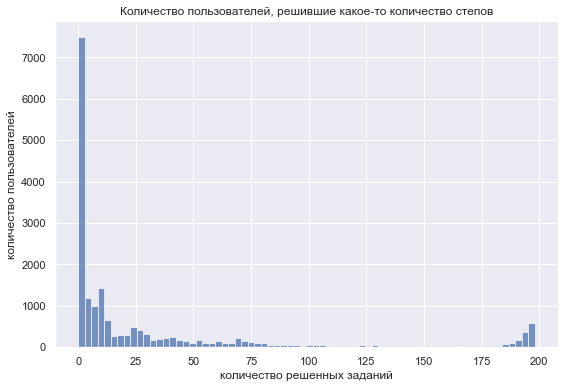

In [265]:
ax = sns.histplot(user_events.passed)
ax.set(xlabel='количество решенных заданий', ylabel='количество пользователей', title='Количество пользователей, решившие какое-то количество степов')
None

In [266]:
#Сколько пользователей не сделали ни одной задачи
user_events.query('passed == 0').shape[0]

1972

In [267]:
# Правильные и неправильные ответы пользователей
user_submissions = submissions_data.pivot_table(
    index='user_id', columns='submission_status', values='step_id', aggfunc='count', fill_value=0
).reset_index().rename_axis('', axis=1)

user_submissions.head()

,user_id,correct,wrong
0,2,2,0
1,3,29,23
2,5,2,2
3,8,9,21
4,14,0,1


In [268]:
# Сколько уникальных дней учились пользователи:
unique_days = events_data.groupby('user_id').day.nunique().to_frame().rename(columns={'day': 'unique_days'})

unique_days.head()

,unique_days
user_id,
1,1
2,2
3,7
5,2
7,1


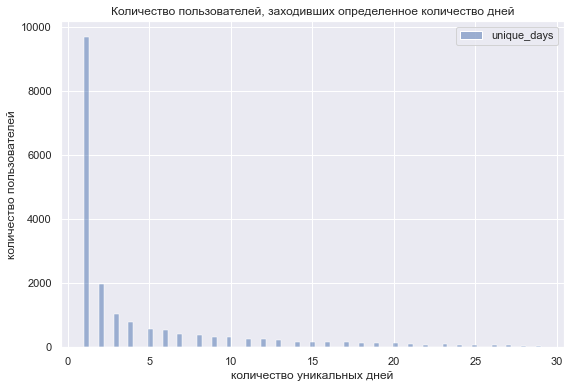

In [269]:
ax = sns.histplot(unique_days.query('unique_days < 30'))
ax.set(xlabel='количество уникальных дней', ylabel='количество пользователей', title='Количество пользователей, заходивших определенное количество дней')
None

In [270]:
unique_days.describe(percentiles=[.51, .6, .61, .66, .67, .7, .71, .73, .74, .75, .76, .78, .79])

,unique_days
count,19234.000000
mean,6.088489
std,12.341683
min,1.000000
50%,1.000000
51%,2.000000
60%,2.000000
61%,3.000000
66%,3.000000
67%,4.000000


In [271]:
STEPS_FOR_PASS = 170

In [272]:
# Посмотрим количество пройденных степов
users = user_events[['user_id', 'passed']].rename(columns={'passed': 'passed_steps'})
users['passed_course'] = users.passed_steps >= STEPS_FOR_PASS
users.passed_course = users.passed_course.map(int)

users.head()

,user_id,passed_steps,passed_course
0,1,0,0
1,2,9,0
2,3,87,0
3,5,11,0
4,7,1,0


In [273]:
# Добавим первый и последний заходы на курс:
users = users.merge(events_data.groupby('user_id').timestamp.min().to_frame().rename(columns={'timestamp': 'first_visit'}), on='user_id')
users = users.merge(events_data.groupby('user_id').timestamp.max().to_frame().rename(columns={'timestamp': 'last_visit'}), on='user_id')

users.head()

,user_id,passed_steps,passed_course,first_visit,last_visit
0,1,0,0,1472827464,1472827464
1,2,9,0,1514383364,1519226966
2,3,87,0,1434358476,1444581588
3,5,11,0,1466156809,1499859939
4,7,1,0,1521634660,1521634660


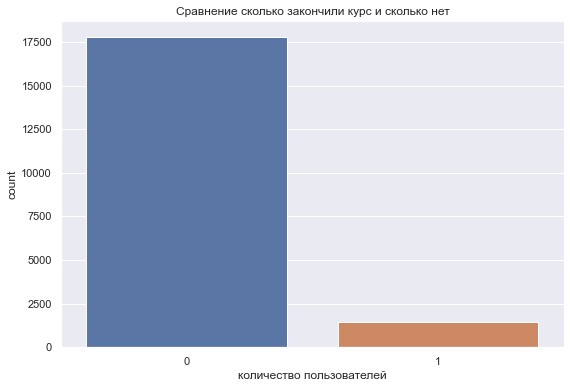

In [274]:
ax = sns.countplot(data=users, x='passed_course')
ax.set(xlabel='количество пользователей', title='Сравнение сколько закончили курс и сколько нет')
None

In [275]:
# Надо понять, пользователи без сертификата еще учатся или уже бросили курс?

# Попробуем 2 подхода:

# 1.
# Изучим длительность обучения пользователей, получивших сертификат.
# Возьмем максимальное количество дней или какой-нибудь 99 персентиль в качестве "порога длительности обучения".
# Если пользователь без сертификата учится дольше, чем порог - считаем что он бросил курс.

# 2.
# Изучим перерывы в обучении у пользователей, получивших сертификат.
# Возьмем максимальный перерыв или какой-нибудь 99 персентиль в качестве "порога длительности отсутствия".
# Если от последнего событитя пользователя до сегодняшнего дня прошло больше времени, чем порог
# - считаем что он бросил курс.

In [276]:
#1


In [277]:
# ID прошедших курс пользователей:
passed_course_user_ids = users[users['passed_course'] == True].user_id
events_of_passed_course_users = events_data[events_data['user_id'].isin(passed_course_user_ids)]

In [278]:
passed_course_user_ids, events_of_passed_course_users

(9           16
 13          22
 18          30
 22          34
 26          39
          ...  
 19190    26740
 19207    26763
 19218    26777
 19220    26779
 19221    26781
 Name: user_id, Length: 1433, dtype: int64,
          step_id   timestamp      action  user_id                date  \
 94         32815  1434342230  discovered     6646 2015-06-15 04:23:50   
 95         32815  1434342230      passed     6646 2015-06-15 04:23:50   
 96         32815  1434342230      viewed     6646 2015-06-15 04:23:50   
 97         32811  1434342233      passed     6646 2015-06-15 04:23:53   
 98         32811  1434342233  discovered     6646 2015-06-15 04:23:53   
 ...          ...         ...         ...      ...                 ...   
 3479642    34026  1526756104      viewed    23194 2018-05-19 18:55:04   
 3479644    33901  1526756106      viewed    23194 2018-05-19 18:55:06   
 3479652    33901  1526756195      viewed    23194 2018-05-19 18:56:35   
 3479653    33899  1526756197      viewe

In [279]:
# Узнаем время правильного решения 170-й задачи. Это и будет время окончания курса.
# Для этого соберем датафрейм из первых 170-ти событий успешного решения практического шага:
tmp = events_of_passed_course_users.query('action == "passed"').sort_values(['user_id', 'timestamp']).groupby('user_id').head(STEPS_FOR_PASS)

tmp.head(STEPS_FOR_PASS + 1)

,step_id,timestamp,action,user_id,date,day,month
282352,32815,1435674765,passed,16,2015-06-30 14:32:45,2015-06-30,2015-06
282363,32811,1435674778,passed,16,2015-06-30 14:32:58,2015-06-30,2015-06
282380,32929,1435674798,passed,16,2015-06-30 14:33:18,2015-06-30,2015-06
282385,32814,1435674800,passed,16,2015-06-30 14:33:20,2015-06-30,2015-06
282417,32812,1435674880,passed,16,2015-06-30 14:34:40,2015-06-30,2015-06
...,...,...,...,...,...,...,...
2826977,33983,1513093702,passed,16,2017-12-12 15:48:22,2017-12-12,2017-12
2826983,33984,1513093777,passed,16,2017-12-12 15:49:37,2017-12-12,2017-12
2827047,34041,1513094276,passed,16,2017-12-12 15:57:56,2017-12-12,2017-12
2827052,33939,1513094298,passed,16,2017-12-12 15:58:18,2017-12-12,2017-12


In [280]:
#максимальная разница во времени - время получения сертификата
obtaining_certs = tmp.groupby('user_id').timestamp.max().to_frame().rename(columns={'timestamp': 'obtaining_cert'})

obtaining_certs.head()

,obtaining_cert
user_id,
16,1513094298
22,1500036463
30,1509095682
34,1504794582
39,1459445025


In [281]:
# Создадим датафрейм, поместим туда прошедших курс пользователей:
passed_course_users = users.query('passed_course == True')

# Добавим время получения сертификата:
passed_course_users = passed_course_users.merge(obtaining_certs, on='user_id')
passed_course_users['days_spent_on_obtaining_cert'] =np.ceil((passed_course_users['obtaining_cert'] -passed_course_users['first_visit']) / (24 * 60 * 60)).map(int)

passed_course_users.head()

,user_id,passed_steps,passed_course,first_visit,last_visit,obtaining_cert,days_spent_on_obtaining_cert
0,16,196,1,1435674765,1513162585,1513094298,897
1,22,198,1,1498561010,1507142631,1500036463,18
2,30,198,1,1467307716,1510574287,1509095682,484
3,34,195,1,1493156230,1525626844,1504794582,135
4,39,198,1,1456943480,1502712399,1459445025,29


<AxesSubplot:>

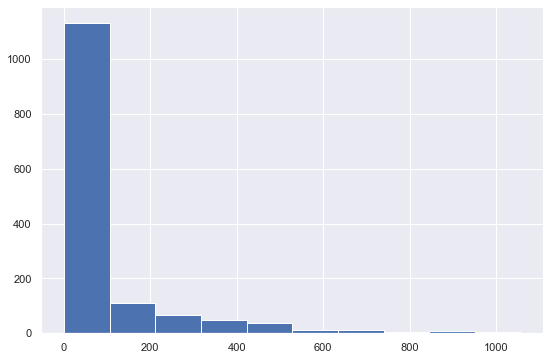

In [282]:
# Ось x - количество дней, ось y - количество учеников:
passed_course_users['days_spent_on_obtaining_cert'].hist()

In [283]:
passed_course_users['days_spent_on_obtaining_cert'].describe(percentiles=[.9, .95, .99])

# Сколько дней обучения брать в качестве порога?

# Например, считаем, что пользователь бросил курс,
# если он не получил сертификат и уже учится более 434 дней (95 персентиль).

# Пользователи, которые не имеют сертификат и учатся меньше 434 дней, будут в неопределенном статусе.
# Посмотрим, сколько таких пользователей будет при взятии различных порогов.

count    1433.000000
mean       92.387299
std       152.200695
min         1.000000
50%        31.000000
90%       283.800000
95%       434.000000
99%       747.440000
max      1056.000000
Name: days_spent_on_obtaining_cert, dtype: float64

In [284]:
# Пользователи без сертификатов:
not_passed_course_users = users.query('passed_course == False')
not_passed_course_users
training_length_threshold = 747 * 24 * 60 * 60

not_passed_course_users.head()

,user_id,passed_steps,passed_course,first_visit,last_visit
0,1,0,0,1472827464,1472827464
1,2,9,0,1514383364,1519226966
2,3,87,0,1434358476,1444581588
3,5,11,0,1466156809,1499859939
4,7,1,0,1521634660,1521634660


In [285]:
# 11417 человек  начали проходить курс меньше чем 747 дня назад (99-й персентиль).
# 7530  человека начали проходить курс меньше чем 434 дня назад (95-й персентиль).
not_passed_course_users.query('first_visit + @training_length_threshold > @now').shape[0]

11417

In [286]:
# Мы потеряем 59.3% пользователей без сертификата в случае взятия 99-го персентиля в качестве порога.
# т.к. они не закончили курс и не бросили его.
# Мы потеряем 39.1% пользователей без сертификата в случае взятия 95-го персентиля в качестве порога.
not_passed_course_users.query('first_visit + @training_length_threshold > @now').shape[0] / users.shape[0]

0.5935842778413226

In [287]:
#2

In [288]:
# Добавим время получения сертификата к событиям пользователей получивших сертификат:
events_of_passed_course_users = events_of_passed_course_users.merge(
    passed_course_users[['user_id', 'obtaining_cert']], on='user_id'
)

events_of_passed_course_users.head()

,step_id,timestamp,action,user_id,date,day,month,obtaining_cert
0,32815,1434342230,discovered,6646,2015-06-15 04:23:50,2015-06-15,2015-06,1437414247
1,32815,1434342230,passed,6646,2015-06-15 04:23:50,2015-06-15,2015-06,1437414247
2,32815,1434342230,viewed,6646,2015-06-15 04:23:50,2015-06-15,2015-06,1437414247
3,32811,1434342233,passed,6646,2015-06-15 04:23:53,2015-06-15,2015-06,1437414247
4,32811,1434342233,discovered,6646,2015-06-15 04:23:53,2015-06-15,2015-06,1437414247


In [289]:
# Для каждого пользователя получим максимальный перерыв между событиями до получения сертификата:
max_breaks_of_passed_course_users = events_of_passed_course_users.query('timestamp <= obtaining_cert')[['user_id', 'timestamp']].groupby('user_id')['timestamp'].apply(list).apply(np.diff).apply(np.max).to_frame().rename(columns={'timestamp': 'max_break'})

max_breaks_of_passed_course_users.head()

,max_break
user_id,
16,61161049
22,263487
30,12567375
34,4938396
39,266880


In [290]:
# Переведем секунды в дни:
max_breaks_of_passed_course_users['max_break'] =np.ceil(max_breaks_of_passed_course_users['max_break'] / (24 * 60 * 60)).map(int)

max_breaks_of_passed_course_users.head()

,max_break
user_id,
16,708
22,4
30,146
34,58
39,4


In [291]:
# Добавим максимальный перерыв между событиями к пользователям, получившим сетрификат:
passed_course_users = passed_course_users.merge(max_breaks_of_passed_course_users, on='user_id')

passed_course_users.head()

,user_id,passed_steps,passed_course,first_visit,last_visit,obtaining_cert,days_spent_on_obtaining_cert,max_break
0,16,196,1,1435674765,1513162585,1513094298,897,708
1,22,198,1,1498561010,1507142631,1500036463,18,4
2,30,198,1,1467307716,1510574287,1509095682,484,146
3,34,195,1,1493156230,1525626844,1504794582,135,58
4,39,198,1,1456943480,1502712399,1459445025,29,4


<AxesSubplot:>

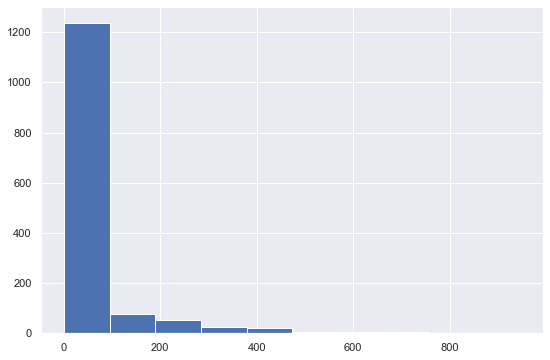

In [292]:
passed_course_users['max_break'].hist()

In [293]:
passed_course_users['max_break'].describe(percentiles=[.9, .95, .99])

# Какой максимальный перерыв брать в качестве порога?
# Посмотрим, сколько пользователей мы "потеряем" при взятии различных порогов.

count    1433.000000
mean       48.413119
std       107.147067
min         1.000000
50%         8.000000
90%       144.000000
95%       274.600000
99%       536.680000
max       947.000000
Name: max_break, dtype: float64

In [294]:
# ID пользователей без сертификата:
not_passed_course_user_ids = users.query('passed_course == False').user_id

not_passed_course_user_ids.head()

0    1
1    2
2    3
3    5
4    7
Name: user_id, dtype: int64

In [295]:
# Отберем события пользователей без сертификата:
events_of_not_passed_course_users = events_data[events_data['user_id'].isin(not_passed_course_user_ids)]

events_of_not_passed_course_users.head()

,step_id,timestamp,action,user_id,date,day,month
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,2015-06
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,2015-06
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,2015-06
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,2015-06
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,2015-06


In [296]:
# Получим максимальный перерыв между событиями для каждого пользователя без сертификата.
# Время от последнего события пользователя до "сегодняшнего" момента тоже надо учесть:
max_breaks_of_not_passed_course_users = events_of_not_passed_course_users[['user_id', 'timestamp']].groupby('user_id')['timestamp'].apply(list).apply(lambda x: x + [now]).apply(np.diff).apply(np.max).to_frame().rename(columns={'timestamp': 'max_break'})

max_breaks_of_not_passed_course_users.head()

,max_break
user_id,
1,53945347
2,7545845
3,82191223
5,33702812
7,5138151


In [297]:
# Переведем секунды в дни:
max_breaks_of_not_passed_course_users['max_break'] =np.ceil(max_breaks_of_not_passed_course_users['max_break'] / (24 * 60 * 60)).map(int)

max_breaks_of_not_passed_course_users.head()

,max_break
user_id,
1,625
2,88
3,952
5,391
7,60


In [298]:
# Добавим максимальный перерыв к пользователям без сертификата:
not_passed_course_users = not_passed_course_users.merge(max_breaks_of_not_passed_course_users, on='user_id')

not_passed_course_users.head()

,user_id,passed_steps,passed_course,first_visit,last_visit,max_break
0,1,0,0,1472827464,1472827464,625
1,2,9,0,1514383364,1519226966,88
2,3,87,0,1434358476,1444581588,952
3,5,11,0,1466156809,1499859939,391
4,7,1,0,1521634660,1521634660,60


In [299]:
breaks_in_training_threshold =536
# Мы потеряем 53.2% пользователей без сертификата если возьмем 99-й персентиль в качестве порога,
# т.к. они не закончили курс, но и не бросили его.
# Мы потеряем 34.3% пользователей без сертификата если возьмем 95-й персентиль в качестве порога.
not_passed_course_users.query('max_break <= @breaks_in_training_threshold').shape[0]/ not_passed_course_users.shape[0]

0.5321611145441267

In [300]:
###

In [301]:
# Добавим ко всем пользователям максимальный перерыв:
users = users.merge(pd.concat([max_breaks_of_passed_course_users, max_breaks_of_not_passed_course_users]),on='user_id')

users.head()

,user_id,passed_steps,passed_course,first_visit,last_visit,max_break
0,1,0,0,1472827464,1472827464,625
1,2,9,0,1514383364,1519226966,88
2,3,87,0,1434358476,1444581588,952
3,5,11,0,1466156809,1499859939,391
4,7,1,0,1521634660,1521634660,60


In [302]:
# Отметим покинувших курс пользователей:
users['is_gone'] = 0
users.loc[(users['passed_course'] == 0) & (users['max_break'] > breaks_in_training_threshold), 'is_gone'] = 1

users.head()

,user_id,passed_steps,passed_course,first_visit,last_visit,max_break,is_gone
0,1,0,0,1472827464,1472827464,625,1
1,2,9,0,1514383364,1519226966,88,0
2,3,87,0,1434358476,1444581588,952,1
3,5,11,0,1466156809,1499859939,391,0
4,7,1,0,1521634660,1521634660,60,0


In [303]:
# Посмотрим комбинации количества учащихся, прошедших курс и покинувших курс:
users.groupby(['passed_course', 'is_gone'])['user_id'].count()

passed_course  is_gone
0              0          9473
               1          8328
1              0          1433
Name: user_id, dtype: int64

In [304]:
# Удалим пользователей в "неопределенном" статусе, которые и не прошли курс, и не успели его бросить:
users = users[(users['is_gone'] == True) | (users['passed_course'] == True)]
users

,user_id,passed_steps,passed_course,first_visit,last_visit,max_break,is_gone
0,1,0,0,1472827464,1472827464,625,1
2,3,87,0,1434358476,1444581588,952,1
8,14,3,0,1436366155,1436368676,1047,1
9,16,196,1,1435674765,1513162585,708,0
10,17,5,0,1465762612,1465765342,707,1
...,...,...,...,...,...,...,...
19220,26779,196,1,1473155734,1520157100,8,0
19221,26781,198,1,1487693786,1507540704,20,0
19223,26783,10,0,1434542952,1434543274,1068,1
19228,26789,2,0,1447263411,1447263419,921,1


In [305]:
# Мы удалили из выборки 9473 пользователя, поэтому изменился дисбаланс классов.
# Процентное соотношение прошедших и непрошедших курс:
users['passed_course'].value_counts(normalize=True)

# А было соотношение 92.5 на 7.5

0    0.853191
1    0.146809
Name: passed_course, dtype: float64

In [306]:
# Колонка "is_gone" - полная противоположность колонки "passed_course".
# Будем предсказывать именно ушедщих с курса:
users = users.drop('passed_course', axis=1)
users

,user_id,passed_steps,first_visit,last_visit,max_break,is_gone
0,1,0,1472827464,1472827464,625,1
2,3,87,1434358476,1444581588,952,1
8,14,3,1436366155,1436368676,1047,1
9,16,196,1435674765,1513162585,708,0
10,17,5,1465762612,1465765342,707,1
...,...,...,...,...,...,...
19220,26779,196,1473155734,1520157100,8,0
19221,26781,198,1487693786,1507540704,20,0
19223,26783,10,1434542952,1434543274,1068,1
19228,26789,2,1447263411,1447263419,921,1


<AxesSubplot:xlabel='is_gone', ylabel='count'>

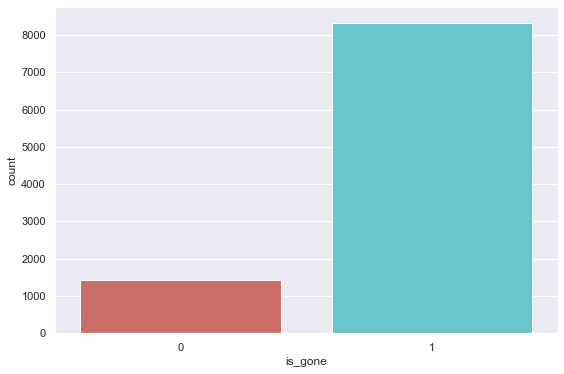

In [307]:
# Визуализируем:
sns.countplot(x='is_gone', data=users, palette='hls')

In [308]:
###

In [309]:
# Нужно предсказать, что пользователь покинет курс как можно раньше, пока он еще здесь.
# Правда ли, что по поведению пользователя на курсе за первую неделю (или несколько дней)
# можно предсказать закончит он курс или нет?

# Попробуем порог в 3 дня:

learning_time_threshold = 2 * 24 * 60 * 60

# Спойлер - чем больше дней - тем лучше предсказывают модели.

In [310]:
# Узнаем время первого захода на курс:
first_visits = events_data.groupby('user_id').timestamp.min().to_frame().rename(columns={'timestamp': 'first_visit'})

In [311]:
# Для каждого пользователя отберем события, которые с ним происходили в течение первых 3 дней:
events_train = events_data[events_data['user_id'].isin(users['user_id'])]
events_train = events_train.merge(first_visits, on='user_id')
events_train = events_train.query("timestamp - first_visit <= @learning_time_threshold")
events_train

,step_id,timestamp,action,user_id,date,day,month,first_visit
0,32815,1434341931,passed,12494,2015-06-15 04:18:51,2015-06-15,2015-06,1434341931
1,32815,1434341931,discovered,12494,2015-06-15 04:18:51,2015-06-15,2015-06,1434341931
2,32815,1434341931,viewed,12494,2015-06-15 04:18:51,2015-06-15,2015-06,1434341931
3,32811,1434341937,viewed,12494,2015-06-15 04:18:57,2015-06-15,2015-06,1434341931
4,32811,1434341937,passed,12494,2015-06-15 04:18:57,2015-06-15,2015-06,1434341931
...,...,...,...,...,...,...,...,...
2191543,33415,1525125184,viewed,5573,2018-04-30 21:53:04,2018-04-30,2018-04,1524955364
2191544,33415,1525126412,passed,5573,2018-04-30 22:13:32,2018-04-30,2018-04,1524955364
2191545,33418,1525126505,discovered,5573,2018-04-30 22:15:05,2018-04-30,2018-04,1524955364
2191546,33418,1525126505,started_attempt,5573,2018-04-30 22:15:05,2018-04-30,2018-04,1524955364


In [312]:
# Проверим, что данные действительно за 3 дня:
events_train.groupby('user_id').day.nunique().max()

3

In [313]:
# Для каждого пользователя отберем сабмиты, которые они отправляли в течение первых 3 дней:
submissions_train = submissions_data[submissions_data['user_id'].isin(users['user_id'])]
submissions_train = submissions_train.merge(first_visits, on='user_id')
submissions_train = submissions_train.query('timestamp - first_visit <= @learning_time_threshold')
submissions_train

,step_id,timestamp,submission_status,user_id,date,day,first_visit
0,31971,1434349275,correct,15853,2015-06-15 06:21:15,2015-06-15,1434345977
1,31972,1434348300,correct,15853,2015-06-15 06:05:00,2015-06-15,1434345977
4,31976,1434348123,wrong,15853,2015-06-15 06:02:03,2015-06-15,1434345977
5,31976,1434348188,correct,15853,2015-06-15 06:03:08,2015-06-15,1434345977
7,31977,1434347371,correct,15853,2015-06-15 05:49:31,2015-06-15,1434345977
...,...,...,...,...,...,...,...
330465,120745,1476419925,wrong,10312,2016-10-14 04:38:45,2016-10-14,1476417044
330466,120745,1476419953,correct,10312,2016-10-14 04:39:13,2016-10-14,1476417044
330467,120745,1476767714,correct,21817,2016-10-18 05:15:14,2016-10-18,1476767576
330470,120745,1478563508,correct,26766,2016-11-08 00:05:08,2016-11-08,1478561209


In [314]:
# Проверим, что данные действительно за 3 дня:
submissions_train.groupby('user_id').day.nunique().max()

3

In [315]:
# Соберем X:
X = users[['user_id','is_gone']]

# Посчитаем количество уникальных дней, в которые пользователь решал задачи:
days_of_training = submissions_train.groupby('user_id').date.nunique().to_frame().rename(columns={'date': 'days_of_training'})

# Посчитаем количество задач, которые пользователь попробовал решить:
steps_tried = submissions_train.groupby('user_id').step_id.nunique().to_frame().rename(columns={'step_id': 'tasks_tried'})

# Посчитаем количество правильных и неправильных ответов:
submission_statuses = submissions_train.pivot_table(
    index='user_id', columns='submission_status', values='step_id', aggfunc='count', fill_value=0
)

# Посчитаем количество просмотренных шагов:
viewed = events_train.pivot_table(
    index='user_id', columns='action', values='step_id', aggfunc='count', fill_value=0
).reset_index().rename_axis('', axis=1)[['user_id', 'viewed']]

X = X.merge(days_of_training, on='user_id', how='outer')
X = X.merge(steps_tried, on='user_id', how='outer')
X = X.merge(submission_statuses, on='user_id', how='outer')
X = X.merge(viewed, on='user_id')
X

,user_id,is_gone,days_of_training,tasks_tried,correct,wrong,viewed
0,1,1,NaN,NaN,NaN,NaN,1
1,3,1,8.0,4.0,4.0,4.0,20
2,14,1,1.0,1.0,0.0,1.0,9
3,16,0,41.0,18.0,18.0,23.0,117
4,17,1,2.0,1.0,0.0,2.0,13
...,...,...,...,...,...,...,...
9756,26779,0,2.0,2.0,2.0,0.0,14
9757,26781,0,NaN,NaN,NaN,NaN,6
9758,26783,1,2.0,2.0,2.0,0.0,20
9759,26789,1,NaN,NaN,NaN,NaN,2


In [316]:
# Рассчитаем процент правильных ответов:
X['correct_ratio'] = X['correct'] / (X['correct'] + X['wrong'])

# Заполним ячейки со значением "Nan" нулями:
X = X.fillna(0)

# Конвертируем значения в целые числа:
for col in ['days_of_training', 'tasks_tried', 'correct', 'wrong']:
    X[col] = X[col].map(int)

# Сделаем индекс по ID пользователя:
X = X.rename_axis('', axis=1).set_index('user_id')
X

,is_gone,days_of_training,tasks_tried,correct,wrong,viewed,correct_ratio
user_id,,,,,,,
1,1,0,0,0,0,1,0.000000
3,1,8,4,4,4,20,0.500000
14,1,1,1,0,1,9,0.000000
16,0,41,18,18,23,117,0.439024
17,1,2,1,0,2,13,0.000000
...,...,...,...,...,...,...,...
26779,0,2,2,2,0,14,1.000000
26781,0,0,0,0,0,6,0.000000
26783,1,2,2,2,0,20,1.000000


In [317]:
# Соберем y:
y = X['is_gone']

# Удалим колонку "is_gone" из X:
X = X.drop(['is_gone'], axis=1)
X

,days_of_training,tasks_tried,correct,wrong,viewed,correct_ratio
user_id,,,,,,
1,0,0,0,0,1,0.000000
3,8,4,4,4,20,0.500000
14,1,1,0,1,9,0.000000
16,41,18,18,23,117,0.439024
17,2,1,0,2,13,0.000000
...,...,...,...,...,...,...
26779,2,2,2,0,14,1.000000
26781,0,0,0,0,6,0.000000
26783,2,2,2,0,20,1.000000


In [318]:
y

user_id
1        1
3        1
14       1
16       0
17       1
        ..
26779    0
26781    0
26783    1
26789    1
26790    1
Name: is_gone, Length: 9761, dtype: int64

In [332]:
X.to_csv('X.csv')
y.to_csv('y.csv')

#Модели

In [319]:
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier

In [320]:
# Разделим данные на тренировочные и тестовые 4 к 1:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.66, random_state=0)

In [321]:
# Найдем найлучшую глубину дерева решений:
grid_search_cv_clf = GridSearchCV(
    tree.DecisionTreeClassifier(criterion='entropy', min_samples_leaf=10, random_state=0),
    {'max_depth': range(1, 5)},
    cv=5
)

In [322]:
# Обучим модель:
grid_search_cv_clf.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(criterion='entropy',
                                              min_samples_leaf=10,
                                              random_state=0),
             param_grid={'max_depth': range(1, 5)})

In [323]:
# Посмотрим лучшую модель:
best_clf = grid_search_cv_clf.best_estimator_
best_clf

DecisionTreeClassifier(criterion='entropy', max_depth=2, min_samples_leaf=10,
                       random_state=0)

In [324]:
# Посмотрим точность на тестовых данных:
best_clf.score(X_test, y_test)

0.8782765893341368

In [325]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_roc_curve, roc_curve

In [1]:
#fpr, tpr, _ = roc_curve(y_score=y_pred, y_true=y_test)
#create ROC curve
#plt.ylabel('True Positive Rate')
#plt.xlabel('False Positive Rate')
#plt.show()
jopa

NameError: name 'jopa' is not defined

In [327]:
from sklearn.ensemble import GradientBoostingClassifier

In [328]:
params = {'n_estimators':200,
          'max_depth':12,
          'criterion':'squared_error',
          'learning_rate':0.03,
          'min_samples_leaf':16,
          'min_samples_split':16
          }

In [329]:
clf = GradientBoostingClassifier(**params)
clf.fit(X_train, y_train)
roc_auc_score(y_score=clf.predict_proba(X_test)[:, 1], y_true=y_test)

0.8268838675622687

In [330]:
rf = RandomForestClassifier(n_estimators=100, n_jobs=2,
                            min_samples_leaf=10, min_samples_split=10,
                            class_weight='balanced')

rf.fit(X_train, y_train)
pred_proba = rf.predict_proba(X_test)
roc_score = roc_auc_score(y_test, pred_proba[:, 1])
print('roc на test', roc_score)

roc на test 0.8364790339795125


In [331]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
roc_auc_score(y_true=y_test, y_score=log_reg.predict_proba(X_test)[:,1])



0.8473735194143783

In [334]:
y

user_id
1        1
3        1
14       1
16       0
17       1
        ..
26779    0
26781    0
26783    1
26789    1
26790    1
Name: is_gone, Length: 9761, dtype: int64